### Compartment	Abbrev	Notes
- CCO-PILUS	l	Pili extend outside the cell
- CCO-FLAGELLUM	s	External structure
- CCO-CELL-PROJECTION	j	External projection
- CCO-EXTRACELLULAR	e	Surrounds the cell
- CCO-OUTER-MEM	o	Surrounds periplasm
- CCO-PERI-BAC	p	Periplasmic space
- CCO-PM-BAC-NEG	i	Inner membrane (plasma membrane)
- CCO-MEMBRANE	m	Likely general membrane layer (see below)
- CCO-CYTOSOL	c	Inside the inner membrane

```
   (l) (s) (j)
     \  |  /
      (e) - extracellular
       |
      (o) - outer membrane
       |
      (p) - periplasm
       |
      (i) - inner membrane / PM
       |
      (c) - cytosol
```

In [4]:
%cd notebooks/
from resolve import resolve
resolve()

[Errno 2] No such file or directory: 'notebooks/'
/Users/alexanderpatrie/Desktop/repos/ecoli/qEcoli/notebooks


In [ ]:
def get_edges() -> list[tuple[str, str]]:
    from spreadsheets import read_tsv
    import polars as pl 
    import pandas as pd

    c_fp = '/Users/alexanderpatrie/Desktop/repos/ecoli/sms-api/sms-api-gateway/resources/reconstruction/ecoli/flat/compartments.tsv'
    c_df = pd.DataFrame(
        read_tsv(c_fp)
    )
    data = [(i, a) for i, a in c_df[['id', 'abbrev']].to_numpy()]
    mapping_c = dict(zip(
        [d[1] for d in data],
        [d[0] for d in data]
        
    ))
    abbrev_edges = [
        ("l", "e"),
        ("s", "e"),
        ("j", "e"),
        ("e", "o"),
        ("o", "p"),
        ("p", "i"),
        ("i", "c"),
        ("m", "i"),
        ("m", "o")
    ]
    return [
        (mapping_c[i], mapping_c[j]) for i, j in abbrev_edges
    ]


def get_nodes(edges):
    nodes = []
    for i, j in edges:
        nodes.append(i)
        nodes.append(j)
    nodes = set(nodes)
    return list(nodes)


def get_chebi_ids(stoichiometry: dict[str, int], session):
    import xmltodict
    from pprint import pp 

    for enz_rxn_id in stoichiometry:
        rxn_id = enz_rxn_id.replace('[CCO-CYTOSOL]', '')
        re = session.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{rxn_id}&detail=high&fmt=json')
        oe = xmltodict.parse(re.content)['ptools-xml']  # ['Enzymatic-Reaction']['regulated-by']['Regulation']
        metadata = oe['metadata']
        dblinks = metadata['PGDB']['dblink']
        if "Compound" in oe:
            # pp(oe["Compound"]["cml"])
            pp(oe["Compound"].keys())
        else:
            print(f'Is protein: {rxn_id}')
            pp(oe['metadata']['PGDB'].keys())
            pp(oe['metadata']['PGDB']['dblink'])


import re




Node order: ['CCO-OUT', 'CCI-PERI-BAC-GN', 'CCO-EXTRACELLULAR', 'CCO-OUTER-MEM', 'NIL', 'CCO-PM-BAC-NEG', 'CCI-PM-BAC-NEG-GN', 'CCO-CYTOSOL', 'CCO-PM-BAC-ACT', 'CCO-IN', 'CCO-PERI-BAC', 'CCO-MEMBRANE']
Coupling matrix J:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]]


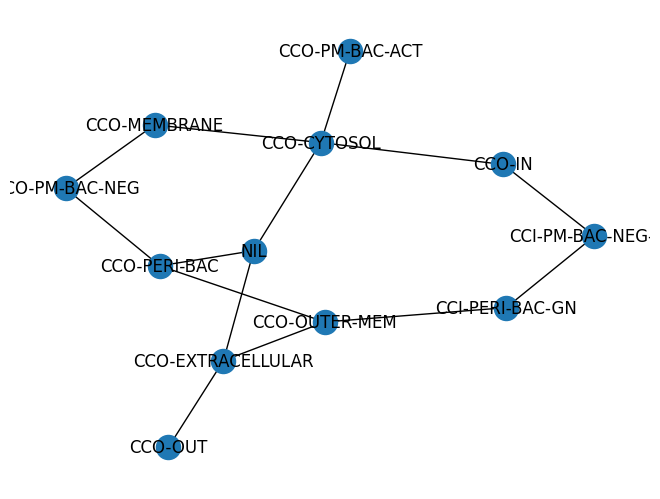

In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from state import find_key

%matplotlib inline 

edges = [
    # Outer environment in contact with outer membrane
    ('CCO-EXTRACELLULAR', 'CCO-OUTER-MEM'),
    ('CCO-EXTRACELLULAR', 'CCO-OUT'),

    # Outer membrane surrounds periplasm
    ('CCO-OUTER-MEM', 'CCO-PERI-BAC'),
    ('CCO-OUTER-MEM', 'CCI-PERI-BAC-GN'),

    # Periplasm lies between outer and inner membrane
    ('CCO-PERI-BAC', 'CCO-PM-BAC-NEG'),
    ('CCI-PERI-BAC-GN', 'CCI-PM-BAC-NEG-GN'),

    # Inner membrane variants
    ('CCO-PM-BAC-NEG', 'CCO-MEMBRANE'),
    ('CCO-MEMBRANE', 'CCO-CYTOSOL'),
    ('CCI-PM-BAC-NEG-GN', 'CCO-IN'),
    ('CCO-PM-BAC-ACT', 'CCO-CYTOSOL'),

    # Direct cytosolic neighbors
    ('CCO-CYTOSOL', 'CCO-IN'),

    # Optional placeholder or nonphysical connections
    ('NIL', 'CCO-CYTOSOL'),
    ('NIL', 'CCO-PERI-BAC'),
    ('NIL', 'CCO-EXTRACELLULAR')
]

nodes = get_nodes(edges)


G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Adjacency matrix (coupling matrix J) with weight = 1
J = nx.to_numpy_array(G, nodelist=nodes)

print("Node order:", nodes)
print("Coupling matrix J:")
print(J)
l = nx.spring_layout(G)
nx.draw(G, l, with_labels=True)
plt.show()


### 1. Load/Prepare/Parse Data:
We draw from the following datasources for parameterization and encoding for our Hamiltonian(s):
- `simData.cPickle`: the output of parameter calculator
- `reaction_data`: a summation of all available metabolic reaction definitions/configs found in `ecoli/reconstruction/ecoli/flat`, read in from corresponding `.tsv` files
- `vivecoli_t2527.json`: (I think) a file containing the WCM output state at `t=2527`.
  
> - TODO: Which processes were used in the composite that generated `vivecoli_t2527.json`? In other words, for which layer is `vivecoli_t2527.json`'s origin? (core? -> antibiotics?, core? -> biomanu.?`).
> - TODO: Ensure that the json file is the most accurate/best version to work with

#### If your phase φ lies in [0,1), and you want to estimate it to n bits of precision, number of qubits needed is:
`nqubits = nEstimationQubits(aka wires) + nUnitaryOperatorQubits`

In [7]:
G.nodes

NodeView(('CCO-OUT', 'CCI-PERI-BAC-GN', 'CCO-EXTRACELLULAR', 'CCO-OUTER-MEM', 'NIL', 'CCO-PM-BAC-NEG', 'CCI-PM-BAC-NEG-GN', 'CCO-CYTOSOL', 'CCO-PM-BAC-ACT', 'CCO-IN', 'CCO-PERI-BAC', 'CCO-MEMBRANE'))

In [8]:
# TODO: can we use these objects to parameterize estimators?
import pickle
import json 

from simdata import reaction_data

# a. vEcoli: reconstruction.ecoli.simulation_data.SimulationDataEcoli
simdata_path = '../resources/reconstruction/sim_data/kb/simData.cPickle'
with open(simdata_path, 'rb') as f:
    simdata = pickle.load(f)
internal_state = simdata.internal_state
external_state = simdata.external_state

# b. qEcoli: simdata.MetabolicReactionData
R = reaction_data.compile()
Rdata = reaction_data.all

# c. vEcoli: data/... Particularly using flux data
output_state_path = '../resources/data/vivecoli_t2527.json'
with open(output_state_path, 'r') as f:
    outstate = json.load(f)['agents']['0']
flux_data_keys = ['reaction_fluxes', 'external_exchange_fluxes', "base_reaction_fluxes", "actual_fluxes", "target_fluxes", "target_fluxes_upper", "target_fluxes_lower"]
rxn_fluxdata = find_key(outstate, 'reaction_fluxes')

In [9]:
Rdata[0]

{'id': '1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN',
 'stoichiometry': {'ACYL-SN-GLYCEROL-3P[CCO-CYTOSOL]': -1,
  'ACYL-ACP[CCO-CYTOSOL]': -1,
  'L-PHOSPHATIDATE[CCO-CYTOSOL]': 1,
  'ACP[CCO-CYTOSOL]': 1},
 'direction': 'L2R',
 'catalyzed_by': ['1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER']}

In [10]:
from equilibrator_api import ComponentContribution, Q_, Reaction
cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

rid = "ACYL-SN-GLYCEROL-3P"

### TODO: This will be our QPE workflow, do it!:
Given:
- `G`: WCM composite/system state
- `S_G`: stoichiometric matrix of size `(m, R)` where:
  - `m`: num metabolites involved in system `G` reactions
  - `R`: num reactions that occur in system `G`

#### 1. Calculate dgprime for each reaction `r` in `R`:
```python
dg_prime_G: list[dict] = []
for r in rxndata.all:
   rxn = cc.parse_reaction_formula(r.formula)
   dg_r = cc.dg_prime(rxn)
   dg_prime_G.append({r.id: dg_r})
```
#### 2. For a matrix `M_prime` of size `(dgR, m, R, kP)`, allocate num wires and construct wire registers across matrix (interpolate?)
#### 3. Map wire registers and problem to existing (hopefully) Ising Hamiltonian:
```python
[dataset] = qml.data.load(
    "qspin", sysname="Ising", periodicity="open", lattice="chain", layout="1x4"
)
```
#### 4. Define QPE circuit parameterized by the initial dataset state and our wires:
```python
dev = qml.device("lightning.qubit", wires=14)

@qml.qnode(dev)
def circuit():
    # Initialize state register to initial state
    qml.StatePrep(initial_state, wires=register["state"])

    # Apply Hadamard gate to all wires in estimation register
    for wire in register["estimation"]:
        qml.Hadamard(wires=wire)

    qml.ControlledSequence(
        qml.Qubitization(H, register["prep"]),
        control=register["estimation"],
    )

    qml.adjoint(qml.QFT)(wires=register["estimation"])

    return qml.probs(wires=register["estimation"])
```
#### 5. Assign energy fingerprint to `G` (something like):
```python
output = circuit()
lamb = sum([abs(c) for c in H.terms()[0]])
print("Eigenvalue: ", lamb * np.cos(2 * np.pi * (np.argmax(output)) / 2 ** len(register["estimation"])))
```


In [11]:
import requests
import json
import xmltodict

s = requests.Session()

with open('../resources/biocyc_credentials.json','r') as f:
    credentials = json.load(f)

s.post('https://websvc.biocyc.org/credentials/login/',
       data={'email': credentials['email'], 'password': credentials['password']})

<Response [200]>

In [21]:
from collections import defaultdict
type(defaultdict(set))

collections.defaultdict

In [26]:
from dataclasses import dataclass
import copy 

def remove_compartment_name(s):
    """Removes text enclosed in square brackets, including the brackets."""
    n = copy.deepcopy(s)
    return re.sub(r'\[.*?\]', '', n).strip()


def extract_compartment_name(compound_id: str) -> str:
    """
    :param compound_id: (`str`) a compound id found in a given reaction's stoichiometry.
        For example: `'ACP[CCO-CYTOSOL]'`
    """
    match = re.search(r'\[([^\[\]]+)\]', compound_id)
    if match:
        return match.group(1)
    else:
        raise ValueError(f"""
            There is no compartment specified in the compound id: {compound_id}. 
            Compartment names are appended in brakets to the compound names like: COMPOUND_NAME[COMPARTMENT_NAME]
        """)


def get_compartments(Rdata: list[dict]):
    C = []
    for r in Rdata:
        S_r = r['stoichiometry']
        for c_name in S_r:
            compartment_c = extract_compartment_name(c_name)
            C.append(compartment_c)
    return list(set(C))

def get_species_names(Rdata: list[dict]):
    names = {}
    for r in Rdata:
        Sr = r['stoichiometry']
        for cname in Sr:
            names[cname] = []

@dataclass 
class SpeciesNodeData:
    from collections import defaultdict
    count: int 
    reactions: defaultdict
    
def species_reaction_map(Rdata: list[dict]):
    def collect(Rdata):
        from collections import defaultdict
        s = defaultdict(set)
        for rxn in Rdata:
            rxn_id = rxn['id']
            stoich = rxn['stoichiometry']
            for species in stoich.keys():
                s[species].add(rxn_id)
        return s
    
    s = collect(Rdata)
    mapping = {}
    for species in s:
        row = s[species]
        mapping[species] = {
            'count': len(row),
            'reactions': row,
            'compartment': extract_compartment_name(species)
        }
    return mapping 


def prepare_species_metadata(Rdata):
    species = species_reaction_map(Rdata)
    compartment_mapping = {s: [] for s in species}
    for s in compartment_mapping:
        cpt = extract_compartment_name(s)
        compartment_mapping[s].append(cpt)
    return {remove_compartment_name(s): list(set(v)) for s, v in compartment_mapping.items()}




node_metadata = prepare_species_metadata(Rdata)
node_metadata


{'ACYL-SN-GLYCEROL-3P': ['CCO-CYTOSOL'],
 'ACYL-ACP': ['CCO-CYTOSOL'],
 'L-PHOSPHATIDATE': ['CCO-PERI-BAC'],
 'ACP': ['CCO-PERI-BAC'],
 '2-DEHYDRO-3-DEOXY-D-GLUCONATE': ['CCO-PERI-BAC'],
 'NAD': ['CCO-EXTRACELLULAR'],
 'CPD-343': ['CCO-CYTOSOL'],
 'NADH': ['CCO-EXTRACELLULAR'],
 'PROTON': ['CCO-IN'],
 'NADP': ['CCO-EXTRACELLULAR'],
 'GLUCONATE': ['CCO-EXTRACELLULAR'],
 'CPD-377': ['CCO-CYTOSOL'],
 'NADPH': ['CCO-EXTRACELLULAR'],
 'GALACTITOL-1-PHOSPHATE': ['CCO-EXTRACELLULAR'],
 'CPD-15826': ['CCO-EXTRACELLULAR'],
 'CPD-13118': ['CCO-EXTRACELLULAR'],
 'GDP-4-DEHYDRO-6-DEOXY-D-MANNOSE': ['CCO-EXTRACELLULAR'],
 '25-DIDEHYDRO-D-GLUCONATE': ['CCO-CYTOSOL'],
 'LACTALD': ['CCO-EXTRACELLULAR'],
 'METHYL-GLYOXAL': ['CCO-EXTRACELLULAR'],
 'MAL': ['CCO-EXTRACELLULAR'],
 'CARBON-DIOXIDE': ['CCO-EXTRACELLULAR'],
 'PYRUVATE': ['CCO-EXTRACELLULAR'],
 'CPD-660': ['CCO-EXTRACELLULAR'],
 'Red-Thioredoxin': ['CCO-CYTOSOL'],
 'Alkyl-Hydro-Peroxides': ['CCO-CYTOSOL'],
 'Ox-Thioredoxin': ['CCO-CYTOSOL'],
 

In [16]:
from collections import defaultdict
x = defaultdict(set)

x['a'].add(11.11)
x['s'] = 2.22
x
    

defaultdict(set, {'a': {11.11}, 's': 2.22})

In [ ]:
import re
import json 




slice_start = 0
slice_end = 1111
data = Rdata[:1111]

def extract_gibbs(Rdata, slice_start: int, slice_end: int):
    dg = {}
    data = Rdata[slice_start:slice_end]
    for rxn in data:
        try:
            rxn_id = remove_bracketed_text(rxn['id'])
            re = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{rxn_id}&detail=high&fmt=json')
            oe = xmltodict.parse(re.content)['ptools-xml']
            dg_r = oe['Reaction'].get('gibbs-0')
            dg[rxn_id] = dg_r
        except:
            continue
    with open(f'../resources/reconstruction/ecoli/flat/dg_{slice_end}.json', 'w') as f:
        json.dump(dg, f, indent=4)
    return dg 

dg = extract_gibbs(data, slice_start, slice_end)


In [9]:
def extract_reactions(Rdata, cc, s):
    rxns_names = ['6PFRUCTPHOS-RXN', 'F16ALDOLASE-RXN', '2TRANSKETO-RXN', 'TRIOSEPISOMERIZATION-RXN']
    # TODO: why does this work for the above reactions, but not for all?
    # rxns_names = [data['id'] for data in Rdata]
    rxns_dict = {}
    stoich_dict = {}
    regulation_dict = {}
    
    for name in rxns_names:
        r = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{name}&detail=low&fmt=json')
        rxn = xmltodict.parse(r.content)['ptools-xml']
        rxn_dict = {}
        stoich_loop_dict = {}
        regulation_loop_dict = {}
        left = rxn['Reaction']['left']
        right = rxn['Reaction']['right'] 
        
        # i will know exact complex in model (connected to rxn), but for now will pick random
        enz_rxn = rxn['Reaction']['enzymatic-reaction']['Enzymatic-Reaction']
        if type(left) is dict:
            left = [left]
        if type(right) is dict:
            right = [right] 
        if type(enz_rxn) is dict:
            enz_rxn = [enz_rxn]
            
        enz_rxn_id =  enz_rxn[0]['@frameid']
        re = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{enz_rxn_id}&detail=high&fmt=json')
        oe = xmltodict.parse(re.content)['ptools-xml']['Enzymatic-Reaction']['regulated-by']['Regulation']
        if type(oe) is dict:
            oe = [oe]
        # add regulators, target regulator directly with id to get info like irreversible, etc
        for regulator in oe:
            reg_name = regulator['regulator']['Compound']['@frameid']
            reg_type = regulator['mode']['#text']
            reg_type = 1 if reg_type == '+' else -1
            regulation_loop_dict[reg_name] = reg_type
            
        for mol in left:
            if type(mol) is dict:
                cid = mol['Compound']['@frameid']
                mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
                rxn_dict[mol_cc] = -1
                stoich_loop_dict[cid] = -1
        for mol in right:
            if type(mol) is dict:
                cid = mol['Compound']['@frameid']
                mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
                rxn_dict[mol_cc] =  1
                stoich_loop_dict[cid] = 1
        rxns_dict[name] = Reaction(rxn_dict)
        stoich_dict[name] = stoich_loop_dict
        regulation_dict[name] = regulation_loop_dict
        
    return rxns_dict, stoich_dict, regulation_dict
    

def estimate_gibbs(rxns_dict: dict, cc):
    (standard_dg_prime, dg_uncertainty) = cc.standard_dg_prime_multi(list(rxns_dict.values()), uncertainty_representation="cov")
    return (standard_dg_prime, dg_uncertainty)


def format_estimation(rxns, dgPrime, dgUncertainty):
    dg_struct = {
        rname: {"dg_prime": 0, "uncertainty": 0} for rname in rxns
    }
    dg_data = dict(zip(rxns.keys(), dgPrime))
    uncertainty_data = dict(zip(rxns.keys(), dgUncertainty))
    for name in dg_struct:
        dg_struct[name]["dg_prime"] = dg_data[name]
        dg_struct[name]["uncertainty"] = uncertainty_data[name]
    return dg_struct


def get_gibbs(Rdata: list[dict], cc: ComponentContribution, s: requests.Session):
    rxns, stoich, regulation = extract_reactions(Rdata, cc, s)
    dgPrime, dgUncertainty = estimate_gibbs(rxns, cc)
    return format_estimation(rxns, dgPrime, dgUncertainty)

In [10]:
rxns, stoich, regulation = extract_reactions(Rdata, cc, s)
dgPrime, dgUncertainty = estimate_gibbs(rxns, cc)

In [11]:
import math

def get_factorization_wires(n: int):
    """
    Given a number n, returns:
    - wires_m: list of wire indices for factor m
    - wires_k: list of wire indices for factor k
    - wires_solution: list of wire indices for m * k
    """
    # Bit length of the product m * k
    bits_solution = math.ceil(math.log2(n))
    
    # Upper bound for m and k is roughly sqrt(n)
    max_factor = math.isqrt(n)
    bits_factor = math.ceil(math.log2(max_factor))
    
    # Assign qubits (wires) sequentially
    wires_m = list(range(bits_factor))
    wires_k = list(range(bits_factor, 2 * bits_factor))
    wires_solution = list(range(2 * bits_factor, 2 * bits_factor + bits_solution))
    
    return wires_m, wires_k, wires_solution


### Performing max-cut with QAOA on a reaction-reaction graph:

In [9]:
# prepare the graph/state
import networkx as nx

def map_metabolites_to_reactions(Rdata: list[dict]):
    from collections import defaultdict
    
    metabolite_to_reactions = defaultdict(set)
    for rxn in Rdata:
        rxn_id = rxn['id']
        stoich = rxn['stoichiometry']
        for met in stoich.keys():
            metabolite_to_reactions[met].add(rxn_id)
    return metabolite_to_reactions


def construct_edges(metabolites_to_reactions) -> set:
    edges = set()
    for reactions in metabolites_to_reactions.values():
        rxn_list = list(reactions)
        for i in range(len(rxn_list)):
            for j in range(i + 1, len(rxn_list)):
                edges.add((rxn_list[i], rxn_list[j]))
    return edges


def construct_graph(mapping, edges):
    import networkx as nx
    G = nx.Graph()
    nodes = list(mapping.keys())
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

def normalize(lst: list[float | int], new_min: int = -1, new_max: int = 1):
    old_min = min(lst)
    old_max = max(lst)
    return [new_min + (x - old_min) * (new_max - new_min) / (old_max - old_min) for x in lst]

data = Rdata[:111]
mapping = map_metabolites_to_reactions(data)
edges = construct_edges(mapping)
G = construct_graph(mapping, edges)

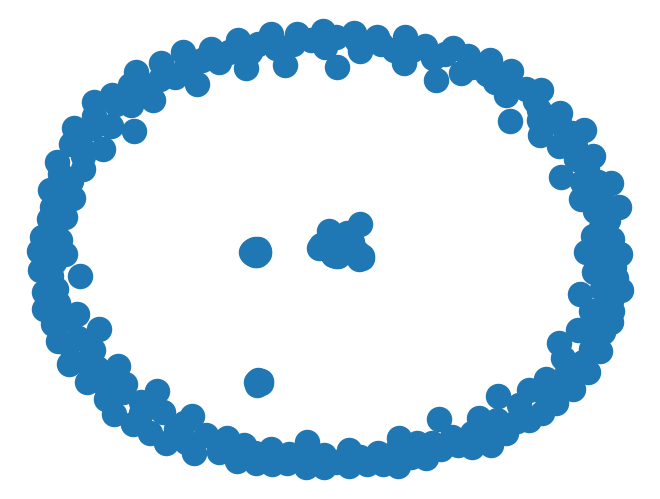

In [10]:
%matplotlib inline 
nx.draw(G, with_labels=False)
plt.show()

In [12]:
# get weights and biasies (higher num shared metabolites ~ higher weight : even bias)

def shared_metabolites(u: str, v: str, mapping):
    # this func should return a list of metabolites that are shared between reaction u and reaction v
    shared = []
    for metabolite_name, reactions_set in mapping.items():
        if u in reactions_set and v in reactions_set:
            shared.append(metabolite_name)
        # else:
        #     shared.append(0)
    return len(shared)

def get_weights(G, mapping):
    raw = [shared_metabolites(u, v, mapping) for u, v in G.edges]
    # raw = [-len(shared_metabolites(u, v, mapping)) for u, v in G.edges]
    # return normalize(raw)
    return normalize(raw)

def get_bias(G, default: int = 0):
    return [default for _ in G.nodes]
    
weights = get_weights(G, mapping)
bias = get_bias(G)

In [13]:
# qaoa/pennylane setup

import pennylane as qml
from matplotlib import pyplot as plt
from pennylane import numpy as np
import scipy
import networkx as nx
import copy

np.random.seed(42)
qubit_number = len(G.nodes)
qubits = range(qubit_number)

n_wires = qubit_number

# Your reaction node labels
reaction_nodes = list(G.nodes)

# Map reaction labels to integers and relable nodes
reaction_to_wire = {reaction: i for i, reaction in enumerate(reaction_nodes)}
wire_to_reaction = {i: reaction for reaction, i in reaction_to_wire.items()}  # optional reverse map
G_mapped = nx.relabel_nodes(G, reaction_to_wire)
graph = G_mapped.edges

# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)

# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        qml.CNOT(wires=edge)
        qml.RZ(gamma, wires=edge[1])
        qml.CNOT(wires=edge)
        # Could also do
        # IsingZZ(gamma, wires=edge)

def bitstring_to_int(bit_string_sample):
    return int(2 ** np.arange(len(bit_string_sample)) @ bit_string_sample[::-1])

In [20]:
dev = qml.device("lightning.qubit", wires=n_wires, shots=20)
register = qml.registers({nodename: 1 for nodename in G_mapped.nodes})

In [21]:
@qml.qnode(dev)
def circuit(gammas, betas, return_samples=False, **kwargs):
    # apply Hadamards to get the n qubit |+> state
    for name, wire in register.items():
        qml.Hadamard(wires=wire)
    # for wire in range(n_wires):
    #     qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for gamma, beta in zip(gammas, betas):
        U_C(gamma)
        U_B(beta)

    if return_samples:
        # sample bitstrings to obtain cuts
        return qml.sample()
    # during the optimization phase we are evaluating the objective using expval
    C = qml.sum(*(qml.Z(w1) @ qml.Z(w2) for w1, w2 in graph))
    return qml.expval(C)


def objective(params):
    """Minimize the negative of the objective function C by postprocessing the QNnode output."""
    return -0.5 * (len(graph) - circuit(*params))

In [22]:
import time

n_layers = 1
init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

def qaoa_maxcut(n_layers=1):
    print(f"\np={n_layers:d}")

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params.copy()
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print(f"Objective after step {i+1:3d}: {-objective(params): .7f}")

    # sample 100 bitstrings by setting return_samples=True and the QNode shot count to 100
    bitstrings = circuit(*params, return_samples=True, shots=100)
    # convert the samples bitstrings to integers
    sampled_ints = [bitstring_to_int(string) for string in bitstrings]
    
    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(sampled_ints))
    most_freq_bit_string = np.argmax(counts)
    print(f"Optimized parameter vectors:\ngamma: {params[0]}\nbeta:  {params[1]}")
    print(f"Most frequently sampled bit string is: {most_freq_bit_string:04b}")

    return -objective(params), sampled_ints


# perform QAOA on our graph with p=1,2 and keep the lists of sampled integers
int_samples1 = qaoa_maxcut(n_layers=1)[1]
int_samples2 = qaoa_maxcut(n_layers=2)[1]


p=1


ValueError: vector

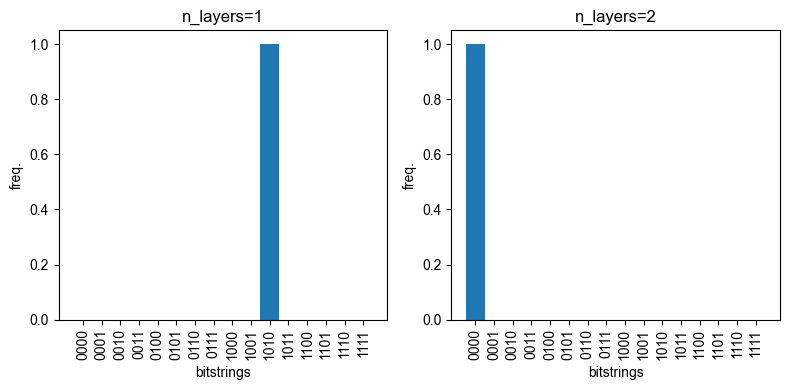

In [20]:
# post-processing/analysis

import matplotlib.pyplot as plt
%matplotlib inline
xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, _ = plt.subplots(1, 2, figsize=(8, 4))
for i, samples in enumerate([int_samples1, int_samples2], start=1):
    plt.subplot(1, 2, i)
    plt.title(f"n_layers={i}")
    plt.xlabel("bitstrings")
    plt.ylabel("freq.")
    plt.xticks(xticks, xtick_labels, rotation="vertical")
    plt.hist(samples, bins=bins)
plt.tight_layout()
plt.show()

In [35]:
# post-processing/packaging
from collections import Counter

# ...assuming int_samples1 is a list of integers from the measurement
bitstrings = list(map(lambda x: format(x, "04b"), int_samples1))  # length-4 binary strings
most_common_bitstring = Counter(bitstrings).most_common(1)[0][0]
print("Most frequent bitstring (best cut):", most_common_bitstring)

def get_cuts(most_common_bitstring, G) -> dict[str, list[str]]:
    # get cuts by reaction indices
    cut_A = [i for i, bit in enumerate(most_common_bitstring) if bit == '0']
    cut_B = [i for i, bit in enumerate(most_common_bitstring) if bit == '1']
    print("Set A:", cut_A)
    print("Set B:", cut_B)

    # get cuts by reaction name
    edgenames = []
    for a, b in set(G.edges):
        edgenames.append(a)
        edgenames.append(b)
    edgenames = list(set(edgenames))
    reaction_to_wire = dict(zip(
        edgenames,
        list(range(len(edgenames)))
    ))
    wire_to_reaction = {v: k for k, v in reaction_to_wire.items()}
    set_0 = [wire_to_reaction[i] for i in cut_A]
    set_1 = [wire_to_reaction[i] for i in cut_B]
    print("Cut A(0) (reactions):", set_0)
    print("Cut B(1) (reactions):", set_1)
    return {"0": set_0, "1": set_1}

cuts = get_cuts(most_common_bitstring, G)
cuts['0']

Most frequent bitstring (best cut): 1110101
Set A: [3, 5]
Set B: [0, 1, 2, 4, 6]
Cut A(0) (reactions): ['1.1.1.215-RXN', '1.1.1.83-RXN']
Cut B(1) (reactions): ['1.1.1.39-RXN', '1.1.1.127-RXN', '1.1.1.271-RXN', '1.1.1.283-RXN', '1.13.11.16-RXN']


['1.1.1.215-RXN', '1.1.1.83-RXN']

In [46]:
node_partition = {
    cut: 0
    for cut in cuts['0'] + cuts['1']
}

for cut in node_partition:
    if cut in cuts['1']:
        node_partition[cut] = 1


# colors = [node_partition[node] for node in G.nodes()]
colors = list(node_partition.values())

In [50]:
len(colors)

7

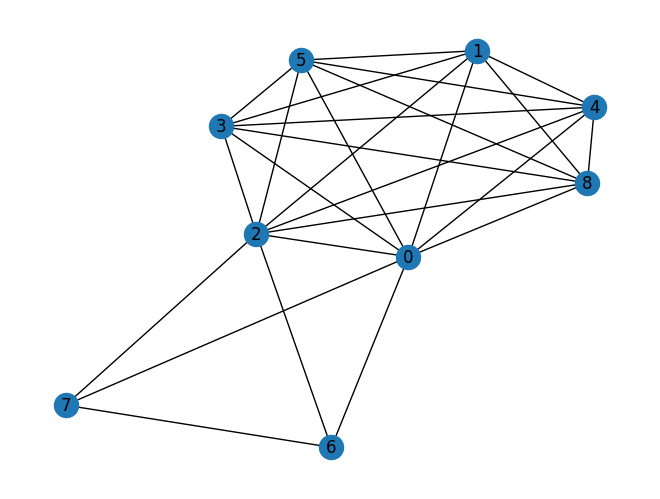

In [49]:
nx.draw(G_mapped, with_labels=True) # node_color=colors, cmap=plt.cm.coolwarm, with_labels=True)

plt.show()

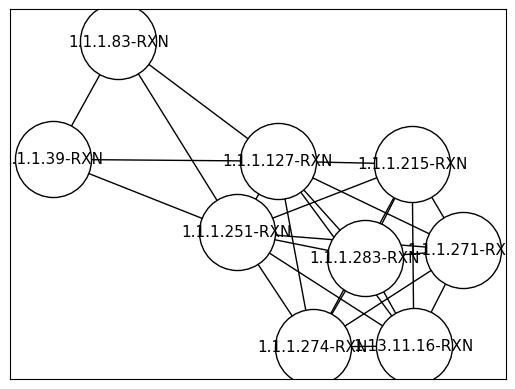

In [31]:
pos = nx.spring_layout(G, seed=1)
options = {
    "font_size": 11,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    # "linewidths": 1,
    # "width": 5,
}
nx.draw_networkx(G, pos, **options)
plt.show()

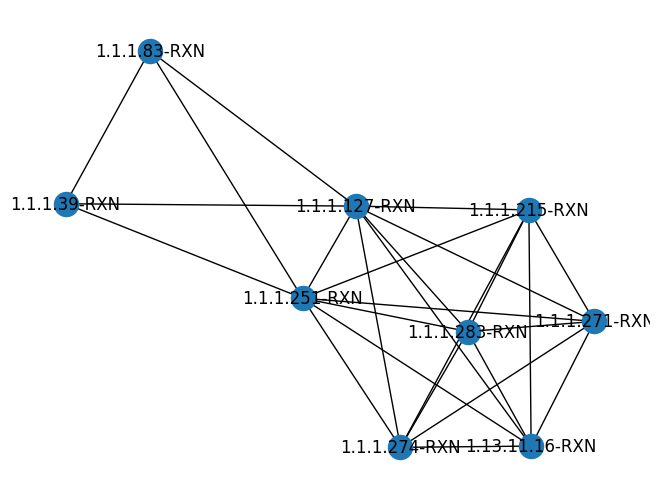

In [32]:
nx.draw(G, with_labels=True, pos=pos)
plt.show()